**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Standard modules needed
import numpy as np
from types import SimpleNamespace
import pandas as pd
import datetime as dt
from types import SimpleNamespace
from scipy import optimize
from scipy import interpolate


%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import exam_prob1 as p1

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [2]:
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.tau = 0.0
par.T = 0.0
par.kappa = 0.1

In [8]:
import numpy as np
from scipy.optimize import minimize
from types import SimpleNamespace
import pandas as pd

# Define parameters
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.tau = 0.0
par.T = 0.0
par.kappa = 0.1

# Functions provided
def labor_star(w, p, par):
    return (p * par.A * par.gamma / w) ** (1 / (1 - par.gamma))

def production_star(w, p, par):
    l_star = labor_star(w, p, par)
    return par.A * l_star ** par.gamma

def profit(w, p, par):
    l_star = labor_star(w, p, par)
    return (1 - par.gamma) / par.gamma * w * l_star

def c1_l(w, p1, p2, T, par, l):
    total_income = w * l + T + profit(w, p1, par) + profit(w, p2, par)
    return par.alpha * total_income / p1

def c2_l(w, p1, p2, tau, T, par, l):
    total_income = w * l + T + profit(w, p1, par) + profit(w, p2, par)
    return (1 - par.alpha) * total_income / (p2 + tau)

def utility(l, w, p1, p2, tau, T, par):
    c1 = c1_l(w, p1, p2, T, par, l)
    c2 = c2_l(w, p1, p2, tau, T, par, l)
    utility_value = np.log(c1**par.alpha * c2**(1 - par.alpha)) - par.nu * (l**(1 + par.epsilon)) / (1 + par.epsilon)
    return -utility_value

# Define a function to check market clearing conditions
def check_market_clearing(p1, p2, w=1, tau=0, T=0):
    # Find the optimal labor supply
    result = minimize(utility, x0=1, args=(w, p1, p2, tau, T, par), bounds=[(0.1, None)])
    l_star = result.x[0]
    
    # Calculate optimal consumption
    c1_star = c1_l(w, p1, p2, T, par, l_star)
    c2_star = c2_l(w, p1, p2, tau, T, par, l_star)
    
    # Calculate optimal production
    y1_star = production_star(w, p1, par)
    y2_star = production_star(w, p2, par)
    
    # Calculate optimal labor for firms
    l1_star = labor_star(w, p1, par)
    l2_star = labor_star(w, p2, par)
    
    # Check market clearing conditions
    labor_market_clearing = np.isclose(l_star, l1_star + l2_star)
    good1_market_clearing = np.isclose(c1_star, y1_star)
    good2_market_clearing = np.isclose(c2_star, y2_star)
    
    return labor_market_clearing, good1_market_clearing, good2_market_clearing

# Prices
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)

# Check market clearing conditions for each combination of p1 and p2
results = []
for p1 in p1_values:
    for p2 in p2_values:
        labor_clearing, good1_clearing, good2_clearing = check_market_clearing(p1, p2)
        results.append({
            'p1': p1,
            'p2': p2,
            'labor_clearing': labor_clearing,
            'good1_clearing': good1_clearing,
            'good2_clearing': good2_clearing
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Adjust pandas display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Print the entire DataFrame
print(results_df)


          p1        p2  labor_clearing  good1_clearing  good2_clearing
0   0.100000  0.100000           False           False           False
1   0.100000  0.311111           False           False           False
2   0.100000  0.522222           False           False           False
3   0.100000  0.733333           False           False           False
4   0.100000  0.944444           False           False           False
5   0.100000  1.155556           False           False           False
6   0.100000  1.366667           False           False           False
7   0.100000  1.577778           False           False           False
8   0.100000  1.788889           False           False           False
9   0.100000  2.000000           False           False           False
10  0.311111  0.100000           False           False           False
11  0.311111  0.311111           False           False           False
12  0.311111  0.522222           False           False           False
13  0.

In [12]:
import numpy as np
from scipy.optimize import minimize, fsolve
from types import SimpleNamespace

# Parameters
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.tau = 0.0
par.T = 0.0

# Derived parameters
w = 1

# Firm functions
def ell_star(p, A, gamma, w):
    return (p * A * gamma / w) ** (1 / (1 - gamma))

def y_star(ell, A, gamma):
    return A * ell ** gamma

def profit_star(p, A, gamma, w):
    ell = ell_star(p, A, gamma, w)
    y = y_star(ell, A, gamma)
    return p * y - w * ell

# Consumer functions
def c1_star(ell, w, T, pi1, pi2, p1, alpha):
    return alpha * (w * ell + T + pi1 + pi2) / p1

def c2_star(ell, w, T, pi1, pi2, p2, tau, alpha):
    return (1 - alpha) * (w * ell + T + pi1 + pi2) / (p2 + tau)

def utility_maximization(ell, par, p1, p2, tau, T):
    pi1 = profit_star(p1, par.A, par.gamma, w)
    pi2 = profit_star(p2, par.A, par.gamma, w)
    c1 = c1_star(ell, w, T, pi1, pi2, p1, par.alpha)
    c2 = c2_star(ell, w, T, pi1, pi2, p2, tau, par.alpha)
    return -(np.log(c1 ** par.alpha * c2 ** (1 - par.alpha)) - par.nu * ell ** (1 + par.epsilon) / (1 + par.epsilon))

# Equilibrium condition functions
def market_clearing(p, par):
    p1, p2 = p
    tau = par.tau
    T = par.T

    # Consumer optimization
    result = minimize(lambda ell: utility_maximization(ell, par, p1, p2, tau, T), x0=1.0, bounds=[(0, None)])
    ell_star_consumer = result.x[0]
    
    pi1 = profit_star(p1, par.A, par.gamma, w)
    pi2 = profit_star(p2, par.A, par.gamma, w)
    
    c1 = c1_star(ell_star_consumer, w, T, pi1, pi2, p1, par.alpha)
    c2 = c2_star(ell_star_consumer, w, T, pi1, pi2, p2, tau, par.alpha)
    
    ell1 = ell_star(p1, par.A, par.gamma, w)
    ell2 = ell_star(p2, par.A, par.gamma, w)
    
    y1 = y_star(ell1, par.A, par.gamma)
    y2 = y_star(ell2, par.A, par.gamma)

    # Market clearing conditions
    labor_market = ell_star_consumer - (ell1 + ell2)
    goods_market_1 = c1 - y1
    goods_market_2 = c2 - y2

    return [labor_market, goods_market_1, goods_market_2]

# Grid search for initial guess
p1_vals = np.linspace(0.1, 2.0, 10)
p2_vals = np.linspace(0.1, 2.0, 10)

# Store potential equilibrium prices
potential_equilibrium_prices = []

# Define a tolerance for market clearing
tolerance = 0.1

# Check market clearing conditions for each combination of p1 and p2
for p1 in p1_vals:
    for p2 in p2_vals:
        clearing_conditions = market_clearing([p1, p2], par)
        labor_market, goods_market_1, goods_market_2 = clearing_conditions
        
        # Print the output for all checked prices
        print(f'Checked prices: p1 = {p1:.5f}, p2 = {p2:.5f} -> '
              f'labor_market = {labor_market:.5f}, goods_market_1 = {goods_market_1:.5f}, goods_market_2 = {goods_market_2:.5f}')
        
        # Check if the clearing conditions are within the tolerance
        if (abs(labor_market) < tolerance and 
            abs(goods_market_1) < tolerance and 
            abs(goods_market_2) < tolerance):
            print(f'Closest to solution: p1 = {p1:.5f}, p2 = {p2:.5f} -> '
                  f'labor_market = {labor_market:.5f}, goods_market_1 = {goods_market_1:.5f}, goods_market_2 = {goods_market_2:.5f}')


Checked prices: p1 = 0.10000, p2 = 0.10000 -> labor_market = 0.99334, goods_market_1 = 2.96001, goods_market_2 = 6.97335
Checked prices: p1 = 0.10000, p2 = 0.31111 -> labor_market = 0.96448, goods_market_1 = 3.00363, goods_market_2 = 2.13467
Checked prices: p1 = 0.10000, p2 = 0.52222 -> labor_market = 0.90630, goods_market_1 = 3.09299, goods_market_2 = 1.14320
Checked prices: p1 = 0.10000, p2 = 0.73333 -> labor_market = 0.81943, goods_market_1 = 3.22995, goods_market_2 = 0.67695
Checked prices: p1 = 0.10000, p2 = 0.94444 -> labor_market = 0.70471, goods_market_1 = 3.41709, goods_market_2 = 0.38435
Checked prices: p1 = 0.10000, p2 = 1.15556 -> labor_market = 0.56320, goods_market_1 = 3.65757, goods_market_2 = 0.17087
Checked prices: p1 = 0.10000, p2 = 1.36667 -> labor_market = 0.39605, goods_market_1 = 3.95483, goods_market_2 = 0.00042
Checked prices: p1 = 0.10000, p2 = 1.57778 -> labor_market = 0.20443, goods_market_1 = 4.31237, goods_market_2 = -0.14375
Checked prices: p1 = 0.10000, p

In [11]:
import numpy as np
from scipy.optimize import minimize, fsolve
from types import SimpleNamespace

# Parameters
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.tau = 0.0
par.T = 0.0

# Derived parameters
w = 1

# Firm functions
def ell_star(p, A, gamma, w):
    return (p * A * gamma / w) ** (1 / (1 - gamma))

def y_star(ell, A, gamma):
    return A * ell ** gamma

def profit_star(p, A, gamma, w):
    ell = ell_star(p, A, gamma, w)
    y = y_star(ell, A, gamma)
    return p * y - w * ell

# Consumer functions
def c1_star(ell, w, T, pi1, pi2, p1, alpha):
    return alpha * (w * ell + T + pi1 + pi2) / p1

def c2_star(ell, w, T, pi1, pi2, p2, tau, alpha):
    return (1 - alpha) * (w * ell + T + pi1 + pi2) / (p2 + tau)

def utility_maximization(ell, par, p1, p2, tau, T):
    pi1 = profit_star(p1, par.A, par.gamma, w)
    pi2 = profit_star(p2, par.A, par.gamma, w)
    c1 = c1_star(ell, w, T, pi1, pi2, p1, par.alpha)
    c2 = c2_star(ell, w, T, pi1, pi2, p2, tau, par.alpha)
    return -(np.log(c1 ** par.alpha * c2 ** (1 - par.alpha)) - par.nu * ell ** (1 + par.epsilon) / (1 + par.epsilon))

# Equilibrium condition functions
def market_clearing(p, par):
    p1, p2 = p
    tau = par.tau
    T = par.T

    # Consumer optimization
    result = minimize(lambda ell: utility_maximization(ell, par, p1, p2, tau, T), x0=1.0, bounds=[(0, None)])
    ell_star_consumer = result.x[0]
    
    pi1 = profit_star(p1, par.A, par.gamma, w)
    pi2 = profit_star(p2, par.A, par.gamma, w)
    
    c1 = c1_star(ell_star_consumer, w, T, pi1, pi2, p1, par.alpha)
    c2 = c2_star(ell_star_consumer, w, T, pi1, pi2, p2, tau, par.alpha)
    
    ell1 = ell_star(p1, par.A, par.gamma, w)
    ell2 = ell_star(p2, par.A, par.gamma, w)
    
    y1 = y_star(ell1, par.A, par.gamma)
    y2 = y_star(ell2, par.A, par.gamma)

    # Market clearing conditions
    labor_market = ell_star_consumer - (ell1 + ell2)
    goods_market_1 = c1 - y1
    goods_market_2 = c2 - y2

    return [labor_market, goods_market_1, goods_market_2]

# Grid search for initial guess
p1_vals = np.linspace(0.1, 2.0, 10)
p2_vals = np.linspace(0.1, 2.0, 10)

# Store all results
results = []

# Check market clearing conditions for each combination of p1 and p2
for p1 in p1_vals:
    for p2 in p2_vals:
        clearing_conditions = market_clearing([p1, p2], par)
        labor_market, goods_market_1, goods_market_2 = clearing_conditions
        
        result = {
            'p1': p1,
            'p2': p2,
            'labor_market': labor_market,
            'goods_market_1': goods_market_1,
            'goods_market_2': goods_market_2
        }
        
        results.append(result)

# Find the closest result to market clearing
closest_result = min(results, key=lambda x: abs(x['labor_market']) + abs(x['goods_market_1']) + abs(x['goods_market_2']))

# Print the closest result
print(f"Closest to solution: p1 = {closest_result['p1']:.5f}, p2 = {closest_result['p2']:.5f} -> "
      f"labor_market = {closest_result['labor_market']:.5f}, goods_market_1 = {closest_result['goods_market_1']:.5f}, goods_market_2 = {closest_result['goods_market_2']:.5f}")


Closest to solution: p1 = 0.94444, p2 = 1.57778 -> labor_market = -0.06181, goods_market_1 = 0.04518, goods_market_2 = -0.06622


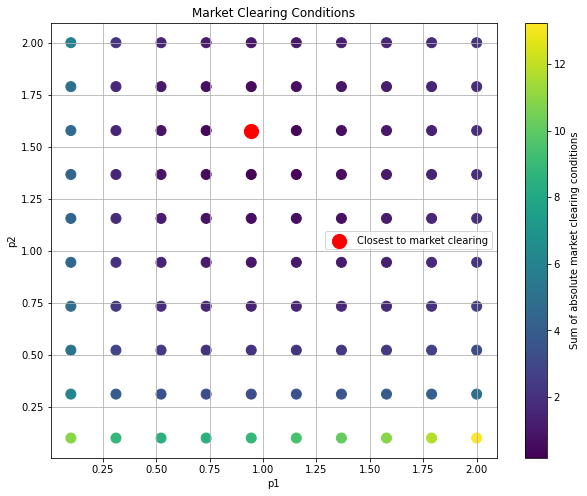

Closest to solution: p1 = 0.94444, p2 = 1.57778 -> labor_market = -0.06181, goods_market_1 = 0.04518, goods_market_2 = -0.06622


In [13]:
import numpy as np
from scipy.optimize import minimize
from types import SimpleNamespace
import matplotlib.pyplot as plt

# Parameters
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.tau = 0.0
par.T = 0.0

# Derived parameters
w = 1

# Firm functions
def ell_star(p, A, gamma, w):
    return (p * A * gamma / w) ** (1 / (1 - gamma))

def y_star(ell, A, gamma):
    return A * ell ** gamma

def profit_star(p, A, gamma, w):
    ell = ell_star(p, A, gamma, w)
    y = y_star(ell, A, gamma)
    return p * y - w * ell

# Consumer functions
def c1_star(ell, w, T, pi1, pi2, p1, alpha):
    return alpha * (w * ell + T + pi1 + pi2) / p1

def c2_star(ell, w, T, pi1, pi2, p2, tau, alpha):
    return (1 - alpha) * (w * ell + T + pi1 + pi2) / (p2 + tau)

def utility_maximization(ell, par, p1, p2, tau, T):
    pi1 = profit_star(p1, par.A, par.gamma, w)
    pi2 = profit_star(p2, par.A, par.gamma, w)
    c1 = c1_star(ell, w, T, pi1, pi2, p1, par.alpha)
    c2 = c2_star(ell, w, T, pi1, pi2, p2, tau, par.alpha)
    return -(np.log(c1 ** par.alpha * c2 ** (1 - par.alpha)) - par.nu * ell ** (1 + par.epsilon) / (1 + par.epsilon))

# Equilibrium condition functions
def market_clearing(p, par):
    p1, p2 = p
    tau = par.tau
    T = par.T

    # Consumer optimization
    result = minimize(lambda ell: utility_maximization(ell, par, p1, p2, tau, T), x0=1.0, bounds=[(0, None)])
    ell_star_consumer = result.x[0]
    
    pi1 = profit_star(p1, par.A, par.gamma, w)
    pi2 = profit_star(p2, par.A, par.gamma, w)
    
    c1 = c1_star(ell_star_consumer, w, T, pi1, pi2, p1, par.alpha)
    c2 = c2_star(ell_star_consumer, w, T, pi1, pi2, p2, tau, par.alpha)
    
    ell1 = ell_star(p1, par.A, par.gamma, w)
    ell2 = ell_star(p2, par.A, par.gamma, w)
    
    y1 = y_star(ell1, par.A, par.gamma)
    y2 = y_star(ell2, par.A, par.gamma)

    # Market clearing conditions
    labor_market = ell_star_consumer - (ell1 + ell2)
    goods_market_1 = c1 - y1
    goods_market_2 = c2 - y2

    return [labor_market, goods_market_1, goods_market_2]

# Grid search for initial guess
p1_vals = np.linspace(0.1, 2.0, 10)
p2_vals = np.linspace(0.1, 2.0, 10)

# Store all results
results = []

# Check market clearing conditions for each combination of p1 and p2
for p1 in p1_vals:
    for p2 in p2_vals:
        clearing_conditions = market_clearing([p1, p2], par)
        labor_market, goods_market_1, goods_market_2 = clearing_conditions
        
        result = {
            'p1': p1,
            'p2': p2,
            'labor_market': labor_market,
            'goods_market_1': goods_market_1,
            'goods_market_2': goods_market_2,
            'clearing_sum': abs(labor_market) + abs(goods_market_1) + abs(goods_market_2)
        }
        
        results.append(result)

# Convert results to numpy arrays for plotting
p1_vals_plot = np.array([res['p1'] for res in results])
p2_vals_plot = np.array([res['p2'] for res in results])
clearing_sums = np.array([res['clearing_sum'] for res in results])

# Find the closest result to market clearing
closest_result = min(results, key=lambda x: x['clearing_sum'])

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(p1_vals_plot, p2_vals_plot, c=clearing_sums, cmap='viridis', s=100)
plt.colorbar(label='Sum of absolute market clearing conditions')
plt.scatter(closest_result['p1'], closest_result['p2'], color='red', s=200, label='Closest to market clearing')
plt.xlabel('p1')
plt.ylabel('p2')
plt.title('Market Clearing Conditions')
plt.legend()
plt.grid(True)
plt.show()

# Print the closest result
print(f"Closest to solution: p1 = {closest_result['p1']:.5f}, p2 = {closest_result['p2']:.5f} -> "
      f"labor_market = {closest_result['labor_market']:.5f}, goods_market_1 = {closest_result['goods_market_1']:.5f}, goods_market_2 = {closest_result['goods_market_2']:.5f}")


In [16]:
# Finding equilibrium prices using fsolve
def reduced_market_clearing(p):
    return market_clearing(p, par)[:2]  # Only use two equations due to Walras' Law

equilibrium_prices = fsolve(reduced_market_clearing, x0=[1.0, 1.0])
print(f'Equilibrium prices: p1 = {equilibrium_prices[0]}, p2 = {equilibrium_prices[1]}')

Equilibrium prices: p1 = 0.9759306450575872, p2 = 1.4907586846678247


In [14]:
import numpy as np
from scipy.optimize import minimize
from types import SimpleNamespace
import matplotlib.pyplot as plt

# Parameters
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.kappa = 0.1

# Derived parameters
w = 1

# Firm functions
def ell_star(p, A, gamma, w):
    return (p * A * gamma / w) ** (1 / (1 - gamma))

def y_star(ell, A, gamma):
    return A * ell ** gamma

def profit_star(p, A, gamma, w):
    ell = ell_star(p, A, gamma, w)
    y = y_star(ell, A, gamma)
    return p * y - w * ell

# Consumer functions
def c1_star(ell, w, T, pi1, pi2, p1, alpha):
    return alpha * (w * ell + T + pi1 + pi2) / p1

def c2_star(ell, w, T, pi1, pi2, p2, tau, alpha):
    return (1 - alpha) * (w * ell + T + pi1 + pi2) / (p2 + tau)

def utility(ell, par, p1, p2, tau, T):
    pi1 = profit_star(p1, par.A, par.gamma, w)
    pi2 = profit_star(p2, par.A, par.gamma, w)
    c1 = c1_star(ell, w, T, pi1, pi2, p1, par.alpha)
    c2 = c2_star(ell, w, T, pi1, pi2, p2, tau, par.alpha)
    return np.log(c1 ** par.alpha * c2 ** (1 - par.alpha)) - par.nu * ell ** (1 + par.epsilon) / (1 + par.epsilon)

# Equilibrium condition functions
def market_clearing(p, par, tau, T):
    p1, p2 = p

    # Consumer optimization
    result = minimize(lambda ell: -utility(ell, par, p1, p2, tau, T), x0=1.0, bounds=[(0, None)])
    ell_star_consumer = result.x[0]
    
    pi1 = profit_star(p1, par.A, par.gamma, w)
    pi2 = profit_star(p2, par.A, par.gamma, w)
    
    c1 = c1_star(ell_star_consumer, w, T, pi1, pi2, p1, par.alpha)
    c2 = c2_star(ell_star_consumer, w, T, pi1, pi2, p2, tau, par.alpha)
    
    ell1 = ell_star(p1, par.A, par.gamma, w)
    ell2 = ell_star(p2, par.A, par.gamma, w)
    
    y1 = y_star(ell1, par.A, par.gamma)
    y2 = y_star(ell2, par.A, par.gamma)

    # Market clearing conditions
    labor_market = ell_star_consumer - (ell1 + ell2)
    goods_market_1 = c1 - y1
    goods_market_2 = c2 - y2

    return labor_market, goods_market_1, goods_market_2, utility(ell_star_consumer, par, p1, p2, tau, T), y2

# Social welfare function
def social_welfare(params, par, p1, p2):
    tau, T = params
    labor_market, goods_market_1, goods_market_2, U, y2 = market_clearing([p1, p2], par, tau, T)
    
    # Ensure market clearing conditions are satisfied
    if np.allclose([labor_market, goods_market_1, goods_market_2], [0, 0, 0], atol=1e-2):
        return -(U - par.kappa * y2)  # We negate because we want to maximize
    else:
        return np.inf  # Large penalty if market doesn't clear

# Initial guesses for p1 and p2
p1 = 1.0
p2 = 1.0

# Initial guesses for tau and T
initial_guess = [0.1, 0.1]

# Bounds for tau and T
bounds = [(0, None), (0, None)]

# Optimize the social welfare function
result = minimize(social_welfare, initial_guess, args=(par, p1, p2), bounds=bounds, method='SLSQP')

# Optimal tau and T
optimal_tau, optimal_T = result.x

# Print the results
print(f'Optimal tau: {optimal_tau:.5f}, Optimal T: {optimal_T:.5f}')

# Recompute the closest to market clearing conditions using the optimal tau and T
labor_market, goods_market_1, goods_market_2, U, y2 = market_clearing([p1, p2], par, optimal_tau, optimal_T)

print(f'Closest to solution: p1 = {p1:.5f}, p2 = {p2:.5f} -> '
      f'labor_market = {labor_market:.5f}, goods_market_1 = {goods_market_1:.5f}, goods_market_2 = {goods_market_2:.5f}')
print(f'Utility: {U:.5f}, y2: {y2:.5f}')
print(f'Social Welfare Function: {U - par.kappa * y2:.5f}')


Optimal tau: 0.10000, Optimal T: 0.10000
Closest to solution: p1 = 1.00000, p2 = 1.00000 -> labor_market = 0.33483, goods_market_1 = -0.06955, goods_market_2 = 0.41308
Utility: -0.51048, y2: 0.50000
Social Welfare Function: -0.56048


/Users/Simon/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [ ]:
from exam_prob1 import check_market_clearing, SimpleNamespace
import numpy as np

# Define parameters using SimpleNamespace
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.tau = 0.0
par.T = 0.0

# Set wage as the numeraire (w = 1)
w = 1.0

# Define values for p1 and p2 using np.linspace
p1_values = np.linspace(0.1, 2.0, 10)  # Array of 10 values from 0.1 to 2.0
p2_values = np.linspace(0.1, 2.0, 10)  # Array of 10 values from 0.1 to 2.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from exam_prob1 import check_market_clearing, par  # Import check_market_clearing and par from exam_prob1.py

# Parameters for the grid
p1_grid = np.linspace(0.1, 2.0, 10)
p2_grid = np.linspace(0.1, 2.0, 10)

# Get market clearing results
market_clearing_grid = check_market_clearing(p1_grid, p2_grid)

# Plotting market clearing conditions
P1, P2 = np.meshgrid(p1_grid, p2_grid)
plt.contourf(P1, P2, market_clearing_grid.T, levels=[0.5, 1.5], colors=['white', 'green'], alpha=0.3)
plt.xlabel('$p_1$')
plt.ylabel('$p_2$')
plt.title('Market Clearing Regions')
plt.colorbar(label='Market Clearing')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import exam_prob1 as q1

# Define p1 and p2 grids
p1_grid = np.linspace(0.1, 2.0, 10)
p2_grid = np.linspace(0.1, 2.0, 10)

# Call check_market_clearing function
market_clearing_grid = q1.check_market_clearing(p1_grid, p2_grid)

# Visualize results or further analyze market clearing_grid
print(market_clearing_grid)  # Optionally print the entire grid for inspection

In [ ]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

In [ ]:
# write you answer here

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [ ]:
# write your answer here

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [ ]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [ ]:
# write your answer here

Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

In [ ]:
# Write your answer here 

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

In [ ]:
# write your answer here

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [ ]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

In [ ]:
# write your answer here

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [ ]:
# write your answer here

Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [ ]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [ ]:
# write your answer here

**Question 4:** Repeat question 3 for all points in the set $Y$.

In [ ]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [ ]:
# write your answer here